# Generación de datos de entrada y funciones de filtrado

In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, firwin, lfilter
from tool._fixedInt import *
from random import *
import sounddevice as sd
import soundfile as sf

In [2]:
NB_INT      = 16
NB_FRAC     = 15
NB_DEPTH    = 15
M           = 3
mu          = 0.05

## Set de microfonos
microfonos = 0
mic_set = 'set1'

if(microfonos):
    ## Señal de interés
    mic1_path = 'audios/'+mic_set+'/signal_plus_noise.wav'
    mic1, fs   = sf.read(mic1_path)

    ## Fuente de ruido
    mic2_path = 'audios/'+mic_set+'/noise_only.wav'
    mic2, fs = sf.read(mic2_path)

    if(len(mic1)>len(mic2)):
        samples = len(mic2)-1
    else:
        samples = len(mic1)-1
    
    Ts      = 1/fs
    T       = samples/fs
    t       = np.arange(0,T, Ts)
else:
    fs      = 44.1e3
    Ts      = 1/fs
    T       = 0.74
    samples = int(T*fs)
    t       = np.arange(0,T, Ts)

    mic1    = chirp(t, 0, T, 20e3, 'linear')
    mic2    = np.zeros(len(t))

N       = len(t)
n       = np.arange(N)

print(N)

## Generación de ruido extra
std_w = np.sqrt(0.5)
w     = std_w * np.random.randn(N)

## Normalizando señal y agregando ruido extra
d_aux   = mic1[:samples]+w
x_aux   = mic2[:samples]+w

## Se aplica filtrado anti-aliasing
h       = firwin(numtaps=10, cutoff=21e3, fs=44.1e3)
d       = lfilter(b=h, a=1.0, x=d_aux)
x       = lfilter(b=h, a=1.0, x=x_aux)

x = x / max(x)
d = d / max(d)

# Datos utilizados en el calculo de los coeficientes
d_aux_fp  = arrayFixedInt(NB_INT, NB_FRAC, d)
x_aux_fp = arrayFixedInt(NB_INT, NB_FRAC, x)

d_fp    = np.array([i.fValue for i in d_aux_fp])
x_fp    = np.array([i.fValue for i in x_aux_fp])

32634


## FIR adaptivo
La función a implementar debe responder al siguiente RTL:

<img src="../../doc/sat_trunc_fir.png">

In [3]:
def adaptive_fir(x,d,h):
    partial_prod    = [DeFixedInt(NB_INT,NB_FRAC), DeFixedInt(NB_INT,NB_FRAC), DeFixedInt(NB_INT,NB_FRAC)]
    partial_sum     = [DeFixedInt(NB_INT,NB_FRAC), DeFixedInt(NB_INT,NB_FRAC), DeFixedInt(NB_INT,NB_FRAC)]

    partial_prod[0].value   = x[0] * h[0]
    partial_prod[1].value   = x[1] * h[1]
    partial_prod[2].value   = x[2] * h[2]

    partial_sum[0].value    = partial_prod[0].fValue + partial_prod[1].fValue
    partial_sum[1].value    = partial_prod[2].fValue + partial_sum[0].fValue
    partial_sum[2].value    = d - partial_sum[1].fValue

    return partial_sum[2].fValue

##  Algoritmo LMS
Ahora, la función que represente las operaciones realizadas por el algoritmo LMS deberá seguir al siguiente RTL:

<img src="../../doc/sat_trunc_lms.png">

In [4]:
def lms(x, h, e):
    h_out = np.zeros(M)
    
    u               = DeFixedInt(NB_INT, NB_FRAC)
    u.value         = mu
    uxe             = DeFixedInt(NB_INT, NB_FRAC)
    uxe.value       = u.fValue * e

    partial_prod    = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]
    partial_sum     = [DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC), DeFixedInt(NB_INT, NB_FRAC)]

    partial_prod[0].value   = uxe.fValue * x[0]
    partial_prod[1].value   = uxe.fValue * x[1]
    partial_prod[2].value   = uxe.fValue * x[2]

    partial_sum[0].value    = partial_prod[0].fValue + h[0]
    partial_sum[1].value    = partial_prod[1].fValue + h[1]
    partial_sum[2].value    = partial_prod[2].fValue + h[2]

    h_out[0]                = partial_sum[0].fValue
    h_out[1]                = partial_sum[1].fValue
    h_out[2]                = partial_sum[2].fValue

    return h_out

## Filtrado de señal con las funciones previas

In [5]:
X       = np.zeros([M,1])
H       = np.zeros([M,N])
e     = []

iteraciones = len(x_fp) - 1
for i in range(iteraciones):
    X[1:, 0] = X[:-1, 0]
    X[0, 0]  = x_fp[i]
    error = adaptive_fir(x=X[:,0], h=H[:,i], d=d_fp[i])
    e.append(error)

    H[:,i+1] = lms(x=X[:,0], h=H[:,i], e=error)




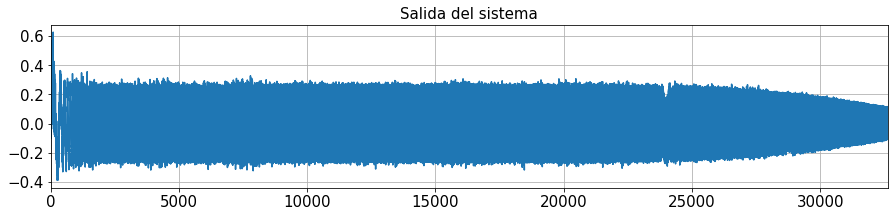

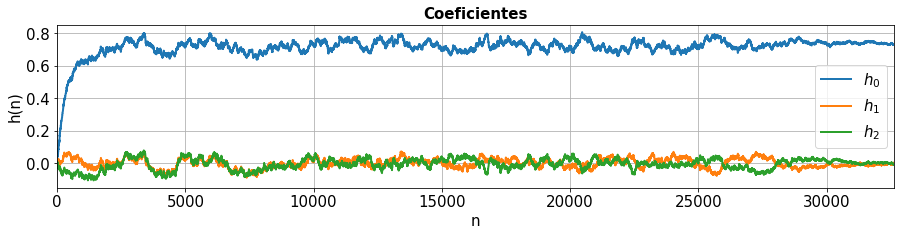

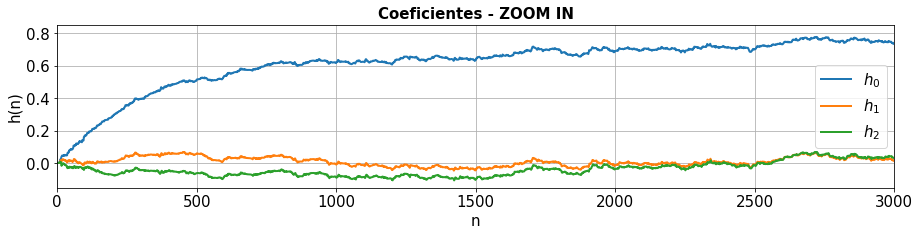

Reproduciendo señal ORIGINAL...
Reproduciendo señal FILTRADA...


In [6]:
# =============================== SALIDAS ===============================
plt.figure(figsize=(15,3))
plt.plot(n[:-1], e)
plt.xlim([0, N])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Salida del sistema", fontsize=15)
plt.grid(True)

# =============================== COEFICIENTES ===============================
colores = ['b', 'r', 'k']
plt.figure(figsize=(15,3))
for i in range(0,M):
    plt.plot(n,H[i,:], linewidth=2, label=f"$h_{i}$")
plt.title("Coeficientes", fontsize=15, fontweight="bold")
plt.xlabel("n", fontsize=15)
plt.ylabel("h(n)", fontsize=15)
plt.xlim([0, N])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

colores = ['b', 'r', 'k']
plt.figure(figsize=(15,3))
for i in range(0,M):
    plt.plot(n,H[i,:], linewidth=2, label=f"$h_{i}$")
plt.title("Coeficientes - ZOOM IN", fontsize=15, fontweight="bold")
plt.xlabel("n", fontsize=15)
plt.ylabel("h(n)", fontsize=15)
plt.xlim([0, 3000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

plt.show()

# Reproduzco señal amplificada
print(f"Reproduciendo señal ORIGINAL...")
sd.play(d, fs)
sd.wait()

print(f"Reproduciendo señal FILTRADA...")
sd.play(e, fs)
sd.wait()

In [7]:
## Guardando señal para testeo
err_hex     = arrayFixedInt(NB_INT, NB_FRAC, e)
mic1_hex    = arrayFixedInt(NB_INT, NB_FRAC, d_fp)
mic2_hex    = arrayFixedInt(NB_INT, NB_FRAC, x_fp)

data = open("out.mem", "w")
for i,v in enumerate(err_hex):
    if(i<2**NB_DEPTH-1):
        data.write(f"0x{v.__hex__()}\n")
data.close()

data = open("mic1.mem", "w")
for i,v in enumerate(mic1_hex):
    if(i<2**NB_DEPTH-1):
        data.write(f"0x{v.__hex__()}\n")
data.close()

data = open("mic2.mem", "w")
for i,v in enumerate(mic2_hex):
    if(i<2**NB_DEPTH-1):
        data.write(f"0x{v.__hex__()}\n")
data.close()